# MNIST CNN Classification with PyTorch on Kaggle

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

## STEP 1: Check GPU Availability

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU Name: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB


## STEP 2: Load and Preprocess MNIST Data

In [48]:
def read_idx(filename):
    """Read IDX file format"""
    with open(filename, 'rb') as f:
        import struct
        magic = struct.unpack('>I', f.read(4))[0]
        if magic == 2051:  # Images
            num_images = struct.unpack('>I', f.read(4))[0]
            rows = struct.unpack('>I', f.read(4))[0]
            cols = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)
        elif magic == 2049:  # Labels
            num_labels = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

In [49]:
# Load data
train_images = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/train-images.idx3-ubyte')
train_labels = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/train-labels.idx1-ubyte')
test_images = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/t10k-images.idx3-ubyte')
test_labels = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/t10k-labels.idx1-ubyte')

print(f"Training set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")

Training set: (60000, 28, 28), Labels: (60000,)
Test set: (10000, 28, 28), Labels: (10000,)


## STEP 3: Data Preprocessing

In [50]:
# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


In [51]:
# Add channel dimension (N, H, W) -> (N, C, H, W)
train_images = train_images[:, np.newaxis, :, :]
test_images = test_images[:, np.newaxis, :, :]


In [52]:
# Create validation split
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

In [53]:
print(f"Training: {X_train.shape}, Validation: {X_val.shape}")

Training: (48000, 1, 28, 28), Validation: (12000, 1, 28, 28)


## STEP 4: Create PyTorch DataLoaders

In [54]:
# Hyperparameter: Batch Size
BATCH_SIZE = 128

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(y_train)
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val), 
    torch.LongTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(test_images), 
    torch.LongTensor(test_labels)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Batches - Train: 375, Val: 94, Test: 79


## STEP 5: Define CNN Architecture

In [55]:
class MNIST_CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(MNIST_CNN, self).__init__()
        
        # Convolutional Layer 1
        # Input: 1x28x28, Output: 32x28x28
        # Hyperparameters: 32 kernels, 3x3 kernel size, stride=1, padding=1
        self.conv1 = nn.Conv2d(
            in_channels=1, 
            out_channels=32, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        
        # Convolutional Layer 2
        # Input: 32x28x28, Output: 64x28x28
        # Hyperparameters: 64 kernels, 3x3 kernel size, stride=1, padding=1
        self.conv2 = nn.Conv2d(
            in_channels=32, 
            out_channels=64, 
            kernel_size=3, 
            stride=1, 
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(64)
        
        # Max Pooling Layer 1
        # Output: 64x14x14
        # Hyperparameters: 2x2 kernel, stride=2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 3
        # Input: 64x14x14, Output: 128x14x14
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Convolutional Layer 4
        # Input: 128x14x14, Output: 128x14x14
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # Max Pooling Layer 2
        # Output: 128x7x7
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Fully Connected Layers
        # Input: 128*7*7 = 6272, Output: 256
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Output layer: 256 -> 10 (digits 0-9)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Convolutional Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout(x)
        
        # Convolutional Block 2
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

## STEP 6: Initialize Model

In [56]:
# Hyperparameters
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4  # L2 regularization
DROPOUT_RATE = 0.5
NUM_EPOCHS = 20

In [57]:
# Create model and move to GPU
model = MNIST_CNN(dropout_rate=DROPOUT_RATE).to(device)


In [58]:
# Loss function
criterion = nn.CrossEntropyLoss()

In [59]:
# Optimizer: Adam with weight decay (L2 regularization)
optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE, 
    weight_decay=WEIGHT_DECAY
)

In [60]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)


In [61]:
# Print model architecture
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
print(model)
print("\nTotal Parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))



MODEL ARCHITECTURE
MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=256, bias=True)
  (bn5): BatchNorm1d(25

## STEP 7: Training Function

In [62]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## STEP 8: Validation Function

In [63]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


## STEP 9: Training Loop

In [65]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

In [66]:
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mnist_cnn.pth')
    
    epoch_time = time.time() - epoch_start
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s)")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 50)

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")


Epoch [1/20] (5.70s)
  Train Loss: 0.1965, Train Acc: 94.66%
  Val Loss: 0.0497, Val Acc: 98.57%
  LR: 0.001000
--------------------------------------------------
Epoch [2/20] (4.64s)
  Train Loss: 0.0680, Train Acc: 97.96%
  Val Loss: 0.0347, Val Acc: 98.86%
  LR: 0.001000
--------------------------------------------------
Epoch [3/20] (4.63s)
  Train Loss: 0.0556, Train Acc: 98.35%
  Val Loss: 0.0362, Val Acc: 98.98%
  LR: 0.001000
--------------------------------------------------
Epoch [4/20] (4.63s)
  Train Loss: 0.0444, Train Acc: 98.69%
  Val Loss: 0.0264, Val Acc: 99.24%
  LR: 0.001000
--------------------------------------------------
Epoch [5/20] (4.61s)
  Train Loss: 0.0408, Train Acc: 98.79%
  Val Loss: 0.0271, Val Acc: 99.17%
  LR: 0.001000
--------------------------------------------------
Epoch [6/20] (4.62s)
  Train Loss: 0.0378, Train Acc: 98.84%
  Val Loss: 0.0252, Val Acc: 99.22%
  LR: 0.001000
--------------------------------------------------
Epoch [7/20] (4.64s)
 

## STEP 10: Evaluate on Test Set

In [67]:
# Load best model
model.load_state_dict(torch.load('best_mnist_cnn.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, device)

print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")


TEST SET RESULTS
Test Loss: 0.0118
Test Accuracy: 99.66%


## STEP 11: Plot Training History

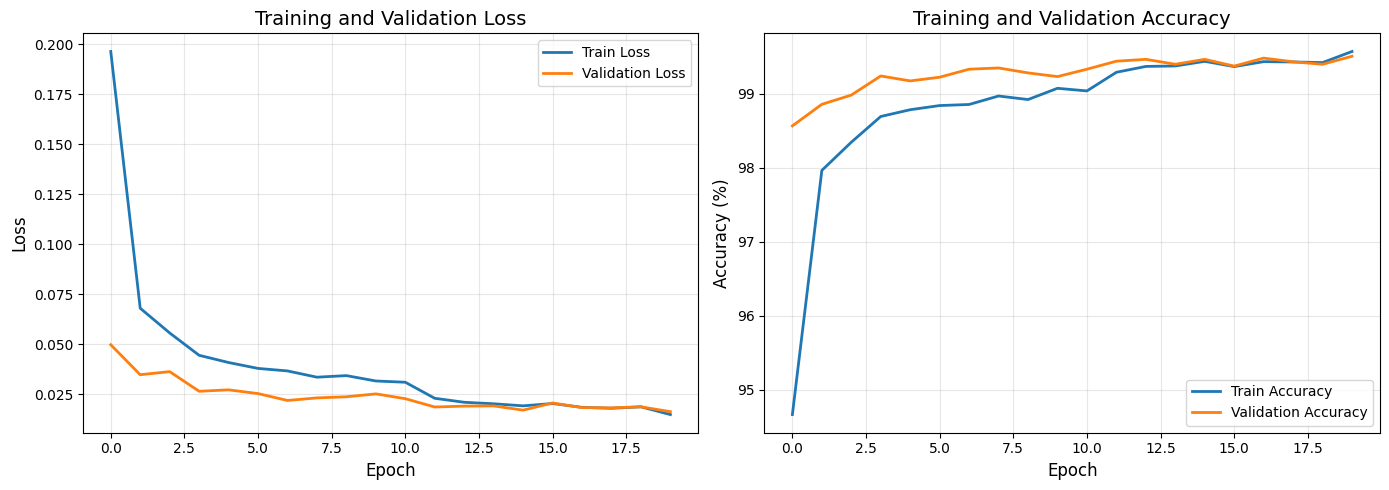

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## STEP 12: Visualize Predictions

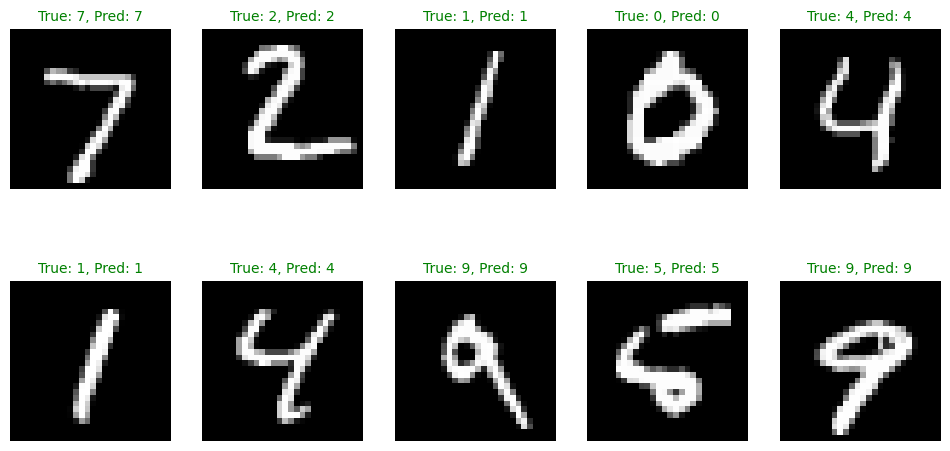

In [69]:
model.eval()
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    
    for i in range(10):
        img = images[i].cpu().squeeze()
        true_label = labels[i].cpu().item()
        pred_label = predictions[i].cpu().item()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {pred_label}', 
                         color=color, fontsize=10)


In [70]:
plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training complete! Model saved as 'best_mnist_cnn.pth'")

<Figure size 640x480 with 0 Axes>


✓ Training complete! Model saved as 'best_mnist_cnn.pth'


# Faster R-CNN Object Detection with PyTorch on Kaggle

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import time
import struct

In [2]:
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)


PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124


## STEP 1: Check GPU Availability

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")



Using device: cuda
GPU Name: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB


## STEP 2: Load MNIST Data

In [4]:
def read_idx(filename):
    """Read IDX file format"""
    with open(filename, 'rb') as f:
        magic = struct.unpack('>I', f.read(4))[0]
        if magic == 2051:  # Images
            num_images = struct.unpack('>I', f.read(4))[0]
            rows = struct.unpack('>I', f.read(4))[0]
            cols = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)
        elif magic == 2049:  # Labels
            num_labels = struct.unpack('>I', f.read(4))[0]
            data = np.frombuffer(f.read(), dtype=np.uint8)
        return data


In [5]:
# Load data
train_images = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/train-images.idx3-ubyte')
train_labels = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/train-labels.idx1-ubyte')
test_images = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/t10k-images.idx3-ubyte')
test_labels = read_idx('/kaggle/input/mnist-dataset-cnn-fasterrcnn/t10k-labels.idx1-ubyte')

print(f"\nTraining set: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Test set: {test_images.shape}, Labels: {test_labels.shape}")



Training set: (60000, 28, 28), Labels: (60000,)
Test set: (10000, 28, 28), Labels: (10000,)


## STEP 3: Prepare Data for Object Detection

In [6]:
def create_digit_image_with_bbox(digit_img, label):
    """
    Create a larger image with the digit and generate bounding box
    This simulates object detection by placing digit on a larger canvas
    """
    # Create a larger canvas (56x56) to place the digit
    canvas_size = 56
    img_size = 28
    
    # Random position for the digit (to make it more interesting)
    max_offset = canvas_size - img_size
    x_offset = np.random.randint(0, max_offset + 1)
    y_offset = np.random.randint(0, max_offset + 1)
    
    # Create canvas
    canvas = np.zeros((canvas_size, canvas_size), dtype=np.uint8)
    
    # Place digit on canvas
    canvas[y_offset:y_offset+img_size, x_offset:x_offset+img_size] = digit_img
    
    # Calculate bounding box [xmin, ymin, xmax, ymax]
    # Find actual digit pixels for tighter bbox
    digit_pixels = digit_img > 30  # threshold
    rows = np.any(digit_pixels, axis=1)
    cols = np.any(digit_pixels, axis=0)
    
    if rows.any() and cols.any():
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        # Add small padding
        padding = 2
        rmin = max(0, rmin - padding)
        rmax = min(img_size - 1, rmax + padding)
        cmin = max(0, cmin - padding)
        cmax = min(img_size - 1, cmax + padding)
        
        # Adjust to canvas coordinates
        bbox = [
            x_offset + cmin,
            y_offset + rmin,
            x_offset + cmax,
            y_offset + rmax
        ]
    else:
        # If no pixels, use full image
        bbox = [x_offset, y_offset, x_offset + img_size - 1, y_offset + img_size - 1]
    
    return canvas, bbox

## STEP 4: Custom Dataset for Faster R-CNN

In [8]:
class MNISTDetectionDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get original digit
        digit_img = self.images[idx]
        label = int(self.labels[idx])
        
        # Create larger image with bounding box
        img, bbox = create_digit_image_with_bbox(digit_img, label)
        
        # Convert to RGB (3 channels) as required by Faster R-CNN
        img = np.stack([img, img, img], axis=2)
        
        # Convert to PIL Image
        img = Image.fromarray(img)
        
        # Normalize to [0, 1]
        img = np.array(img).astype(np.float32) / 255.0
        
        # Convert to tensor [C, H, W]
        img = torch.from_numpy(img).permute(2, 0, 1)
        
        # Prepare target dictionary
        boxes = torch.tensor([bbox], dtype=torch.float32)
        labels_tensor = torch.tensor([label + 1], dtype=torch.int64)  # +1 because 0 is background
        
        target = {
            'boxes': boxes,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((1,), dtype=torch.int64)
        }
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target

## STEP 5: Create Datasets and DataLoaders

In [9]:
# Using subset for faster training 
TRAIN_SIZE = 60000  # Use more for better results: 60000
TEST_SIZE = 10000    # Use more for testing: 10000

train_dataset = MNISTDetectionDataset(
    train_images[:TRAIN_SIZE], 
    train_labels[:TRAIN_SIZE]
)

test_dataset = MNISTDetectionDataset(
    test_images[:TEST_SIZE], 
    test_labels[:TEST_SIZE]
)

print(f"\nDataset sizes - Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# Custom collate function for batch processing
def collate_fn(batch):
    return tuple(zip(*batch))


Dataset sizes - Train: 60000, Test: 10000


In [10]:
# Hyperparameter: Batch Size
BATCH_SIZE = 4  # Faster R-CNN typically uses smaller batches

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    collate_fn=collate_fn,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn,
    num_workers=2
)

print(f"Batches - Train: {len(train_loader)}, Test: {len(test_loader)}")


Batches - Train: 15000, Test: 2500


## STEP 6: Define Faster R-CNN Model

In [11]:
def get_faster_rcnn_model(num_classes):
    """
    Create Faster R-CNN model with ResNet-50 FPN backbone
    
    Architecture Components:
    - Backbone: ResNet-50 with Feature Pyramid Network (FPN)
    - Region Proposal Network (RPN): Generates object proposals
    - RoI Pooling: Extracts fixed-size features from proposals
    - Fast R-CNN Head: Classification and bounding box regression
    """
    
    # Load pre-trained Faster R-CNN model
    # Hyperparameters are built into the architecture:
    # - RPN anchor sizes: (32, 64, 128, 256, 512)
    # - RPN anchor aspect ratios: (0.5, 1.0, 2.0)
    # - RoI pooling output size: 7x7
    # - NMS threshold: 0.7 for training, 0.3 for inference
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    # num_classes = 11 (10 digits + 1 background)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [12]:
# Number of classes: 10 digits + 1 background = 11
NUM_CLASSES = 11

In [13]:
model = get_faster_rcnn_model(NUM_CLASSES)
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 242MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
print("\n" + "="*70)
print("FASTER R-CNN MODEL ARCHITECTURE")
print("="*70)
print("\nBackbone: ResNet-50 with Feature Pyramid Network (FPN)")
print("Region Proposal Network (RPN): Generates region proposals")
print("RoI Align: Extracts features from proposals")
print("Detection Head: Classification + Bounding Box Regression")
print(f"\nNumber of Classes: {NUM_CLASSES} (10 digits + background)")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")



FASTER R-CNN MODEL ARCHITECTURE

Backbone: ResNet-50 with Feature Pyramid Network (FPN)
Region Proposal Network (RPN): Generates region proposals
RoI Align: Extracts features from proposals
Detection Head: Classification + Bounding Box Regression

Number of Classes: 11 (10 digits + background)
Total Parameters: 41,345,286
Trainable Parameters: 41,122,886


## STEP 7: Setup Optimizer and Hyperparameters

In [15]:
# Hyperparameters
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005  # L2 regularization
NUM_EPOCHS = 3

In [16]:
# Optimizer: SGD with momentum (standard for Faster R-CNN)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(
    params, 
    lr=LEARNING_RATE, 
    momentum=MOMENTUM, 
    weight_decay=WEIGHT_DECAY
)


In [17]:
# Learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=3, 
    gamma=0.1
)

In [18]:
print("\n" + "="*70)
print("HYPERPARAMETERS")
print("="*70)
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Momentum: {MOMENTUM}")
print(f"Weight Decay (L2): {WEIGHT_DECAY}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Number of Epochs: {NUM_EPOCHS}")
print(f"Optimizer: SGD with momentum")
print(f"LR Scheduler: StepLR (step_size=3, gamma=0.1)")



HYPERPARAMETERS
Learning Rate: 0.001
Momentum: 0.9
Weight Decay (L2): 0.0005
Batch Size: 4
Number of Epochs: 3
Optimizer: SGD with momentum
LR Scheduler: StepLR (step_size=3, gamma=0.1)


## STEP 8: Training Function

In [19]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    epoch_loss = 0.0
    num_batches = 0
    
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 70)
    
    for batch_idx, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass - model returns loss dict during training
        loss_dict = model(images, targets)
        
        # Calculate total loss
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        num_batches += 1
        
        # Print progress every 500 batches
        if (batch_idx + 1) % 500 == 0:
            avg_loss = epoch_loss / num_batches
            print(f"  Batch [{batch_idx+1}/{len(data_loader)}] | Loss: {avg_loss:.4f}")
    
    return epoch_loss / num_batches

## STEP 9: Evaluation Function

In [20]:
@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        
        # Get predictions
        predictions = model(images)
        
        all_predictions.extend(predictions)
        all_targets.extend(targets)
    
    # Calculate simple accuracy metric
    correct = 0
    total = 0
    
    for pred, target in zip(all_predictions, all_targets):
        if len(pred['boxes']) > 0 and len(target['boxes']) > 0:
            # Get highest scoring prediction
            max_score_idx = pred['scores'].argmax()
            pred_label = pred['labels'][max_score_idx].cpu().item()
            true_label = target['labels'][0].cpu().item()
            
            if pred_label == true_label:
                correct += 1
            total += 1
    
    accuracy = 100 * correct / total if total > 0 else 0
    return accuracy

## STEP 10: Training Loop

In [ ]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

train_losses = []
val_accuracies = []
best_accuracy = 0.0

start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # Train
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    train_losses.append(train_loss)
    
    # Update learning rate
    lr_scheduler.step()
    
    # Evaluate
    val_accuracy = evaluate(model, test_loader, device)
    val_accuracies.append(val_accuracy)
    
    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_faster_rcnn_mnist.pth')
        print(f"  ✓ New best model saved!")
    
    epoch_time = time.time() - epoch_start
    
    print(f"\n  Epoch Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"  Time: {epoch_time:.2f}s")
    print("=" * 70)

total_time = time.time() - start_time
print(f"\nTraining Completed in {total_time/60:.2f} minutes")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")



STARTING TRAINING

Epoch 1/3
----------------------------------------------------------------------
  Batch [500/15000] | Loss: 0.2383
  Batch [1000/15000] | Loss: 0.1715
  Batch [1500/15000] | Loss: 0.1370
  Batch [2000/15000] | Loss: 0.1162
  Batch [2500/15000] | Loss: 0.1025
  Batch [3000/15000] | Loss: 0.0923
  Batch [3500/15000] | Loss: 0.0846
  Batch [4000/15000] | Loss: 0.0785
  Batch [4500/15000] | Loss: 0.0738
  Batch [5000/15000] | Loss: 0.0695
  Batch [5500/15000] | Loss: 0.0662


## STEP 11: Plot Training History

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', linewidth=2, marker='o')
ax1.set_xlabel('Epoch', fontsize=13)
ax1.set_ylabel('Loss', fontsize=13)
ax1.set_title('Training Loss', fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(1, NUM_EPOCHS+1), val_accuracies, 'g-', linewidth=2, marker='s')
ax2.set_xlabel('Epoch', fontsize=13)
ax2.set_ylabel('Accuracy (%)', fontsize=13)
ax2.set_title('Validation Accuracy', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('faster_rcnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# STEP 12: Visualize Predictions

In [ ]:
model.load_state_dict(torch.load('best_faster_rcnn_mnist.pth'))
model.eval()

# Get some test images
test_images_sample = []
test_targets_sample = []

for i in range(12):
    img, target = test_dataset[i]
    test_images_sample.append(img)
    test_targets_sample.append(target)

# Make predictions
with torch.no_grad():
    images_device = [img.to(device) for img in test_images_sample]
    predictions = model(images_device)

# Visualize
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx in range(12):
    img = test_images_sample[idx].cpu().permute(1, 2, 0).numpy()
    target = test_targets_sample[idx]
    pred = predictions[idx]
    
    ax = axes[idx]
    ax.imshow(img[:, :, 0], cmap='gray')
    
    # Draw ground truth box (green)
    gt_box = target['boxes'][0].cpu().numpy()
    gt_label = target['labels'][0].cpu().item() - 1  # Convert back from 1-indexed
    rect_gt = patches.Rectangle(
        (gt_box[0], gt_box[1]), 
        gt_box[2] - gt_box[0], 
        gt_box[3] - gt_box[1],
        linewidth=2, edgecolor='green', facecolor='none', label='Ground Truth'
    )
    ax.add_patch(rect_gt)
    
    # Draw predicted box (red) if available
    if len(pred['boxes']) > 0:
        # Get highest confidence prediction
        max_score_idx = pred['scores'].argmax()
        pred_box = pred['boxes'][max_score_idx].cpu().numpy()
        pred_label = pred['labels'][max_score_idx].cpu().item() - 1
        pred_score = pred['scores'][max_score_idx].cpu().item()
        
        rect_pred = patches.Rectangle(
            (pred_box[0], pred_box[1]), 
            pred_box[2] - pred_box[0], 
            pred_box[3] - pred_box[1],
            linewidth=2, edgecolor='red', facecolor='none', linestyle='--', label='Prediction'
        )
        ax.add_patch(rect_pred)
        
        title = f'GT: {gt_label} | Pred: {pred_label} ({pred_score:.2f})'
        color = 'green' if gt_label == pred_label else 'red'
    else:
        title = f'GT: {gt_label} | Pred: None'
        color = 'red'
    
    ax.set_title(title, fontsize=11, fontweight='bold', color=color)
    ax.axis('off')

In [ ]:
plt.suptitle('Faster R-CNN Predictions (Green=GT, Red=Pred)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('faster_rcnn_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training complete!")
print("✓ Model saved as 'best_faster_rcnn_mnist.pth'")
print("✓ Visualizations saved")
print("\nNote: Faster R-CNN is designed for object detection in complex scenes.")
print("For simple MNIST classification, a standard CNN is more efficient.")